### Importing all the relevant libraries

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import pkg_resources
import pandas as pd
import numpy as np
import sobol_seq
from tabulate import tabulate
import types

def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]
            
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name
imports = list(set(get_imports()))

requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

### Get the estimated expenditure distributions at the member-state level

In [ ]:
df_EU = pd.read_csv('Expenditure.csv')

In [34]:
df_20072013_CZ = df_EU[(df_EU.FundingScheme=='CF_TOTAL')|(df_EU.FundingScheme=='ERDF_TOTAL')].groupby(['ProgrammingPeriod',
                'Country']).get_group(('2007-2013','CZ')).drop('FundingScheme',axis=1)
dist = df_20072013_CZ.groupby(['r'])[[str(y) for y in range(2007,2017)]].sum()

### Get rid of the exceeding figure of the uncertified expenditures

In [35]:
df = pd.read_excel('nuts_prog_kat_Cohesion_codesonly_v3.xlsx',usecols=[0,1,5,6,9,10,11,12])
df_REGIO = df[(df['CCI'].str.contains("161"))|df['CCI'].str.contains("162")]
df_REGIO_capped = df_REGIO[df_REGIO.year<2017]
ER = pd.read_csv('CZK_EURO_historical_exchange_rate.csv')
ExchangeRates = ER.copy()
ExchangeRates['year']=ER.date.astype(str).str[:4].astype(int)
ExchangeRates = ExchangeRates[(ExchangeRates['year']>2006)&(ExchangeRates['year']<2017)]
ExchangeRates=ExchangeRates.drop(['date','conf'],axis=1).set_index('year')
df_REGIO_yearly = df_REGIO_capped.groupby('year')
df_REGIO_su = pd.DataFrame([dfr['EU (czk)'].sum() for idf, dfr in df_REGIO_yearly], 
                            index=[idf for idf, dfr in df_REGIO_yearly],columns=['sum'])
exchange_rate = [ExchangeRates.mean(),ExchangeRates]
er_n = ['Constant','Yearly average']

In [39]:
d_l = []
for i in reversed(df_REGIO_su.index[::9]):
    for ie,er in enumerate(exchange_rate):
        df_REGIO_sum = df_REGIO_su/er.values
        Excess = -dist.iloc[0].sum()+df_REGIO_sum.sum()
        df_REGIO_norm = df_REGIO_sum.copy()
        df_REGIO_norm.loc[i:2016]=df_REGIO_sum.loc[i:2016]-Excess/(2016-i+1)
        d_l.append(df_REGIO_norm)
df_REGIO_normalization = pd.concat(d_l,axis=1)

### Evaluate their relation

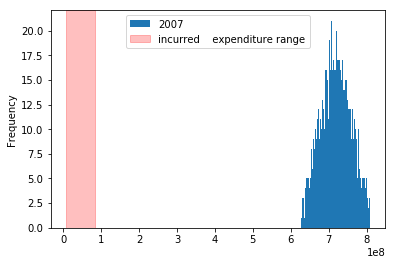

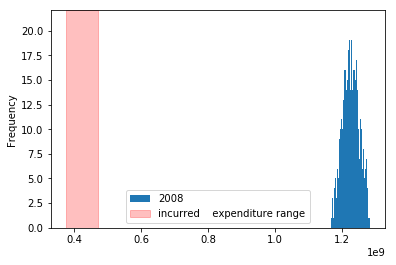

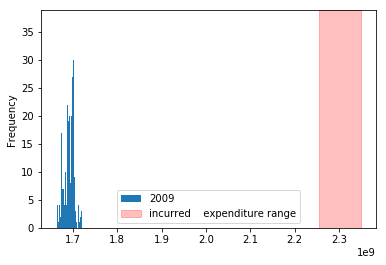

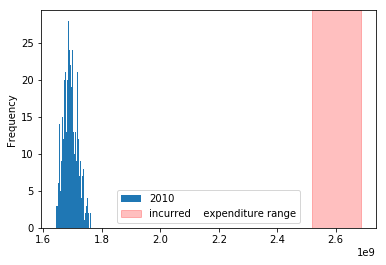

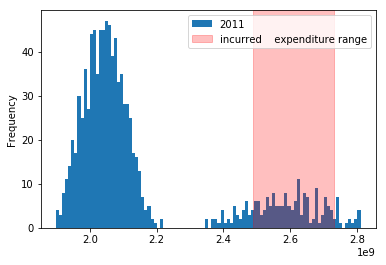

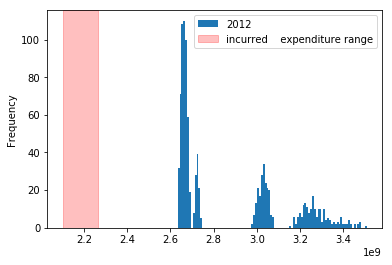

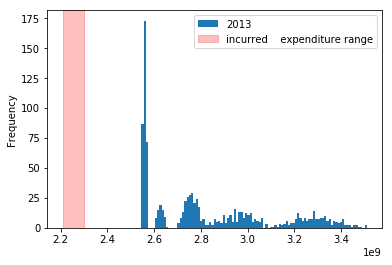

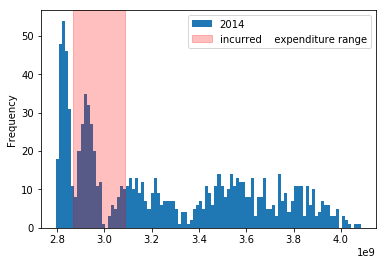

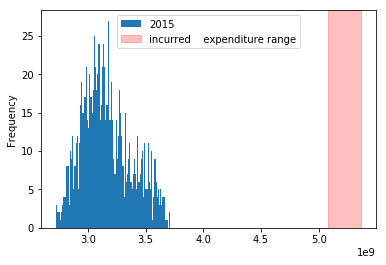

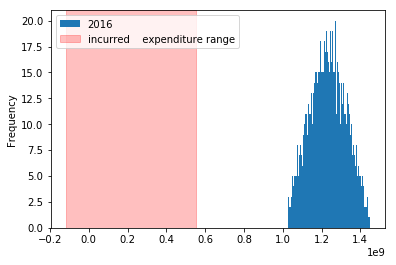

In [40]:
for c in dist:
    dist[c].plot.hist(bins = 100)
    plt.axvspan(df_REGIO_normalization.loc[int(c)].min(), df_REGIO_normalization.loc[int(c)].max(), alpha=0.25, color='red',label='incurred\
    expenditure range')
    plt.legend()
    plt.show()